## Import Library

In [2]:
import awswrangler as wr
import pandas as pd
from contextlib import suppress
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import datetime
import matplotlib.pyplot as plt


/usr/local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [67]:
## 그래프 한글 출력
!apt-get update -qq
!apt-get install fonts-nanum* -qq
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = mpl.font_manager.FontProperties(fname=path).get_name()
mpl.rc('font', family=font_name)
mpl.font_manager._rebuild()

W: GPG error: https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease: The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
E: The repository 'https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease' is no longer signed.


AttributeError: module 'matplotlib.font_manager' has no attribute '_rebuild'

## Load Data

In [6]:
df = wr.s3.read_csv('s3://poc-ktestate/data/raw_data/20~22_total_data.csv')

## Basic PreProcessing

In [7]:
## 공조기 데이터 층수 매핑
floor_dir = {'AHU04': 'AHU_B3F',
             'AHU05': 'AHU_1F',
             'AHU06': 'AHU_2F',
             'AHU07': 'AHU_3F',
             'AHU08': 'AHU_4F',
             'AHU09': 'AHU_5F',
             'AHU13': 'AHU_9F'}
new_columns = []
for column in list(df):
    try:
        new_columns.append('_'.join([floor_dir[column.split('_')[0]],column.split('_')[1]]))
    except:
        new_columns.append(column)
df = pd.DataFrame(columns = new_columns, data = df.values)

## 데이터 형변환
for col in list(df):
    with suppress(Exception): df[col] = df[col].astype('float')
    
## 날짜 변수 추가 (년, 월)
df['시간'] = pd.to_datetime(df['시간'])
df['year'] = df['시간'].dt.year.astype('int')
df['month'] = df['시간'].dt.month.astype('int')

In [8]:
## 단일값 제거 (모든 층수에서 댐퍼와 냉난방밸브 삭제)
single_col = []
for column in list(df):
    if df[column].nunique() == 1:
        print(column, df[column].unique())
        single_col.append(column)        
df.drop(single_col, inplace = True, axis = 1)

AHU_B3F_댐퍼 [0.]
AHU_1F_댐퍼 [0.]
AHU_2F_댐퍼 [0.]
AHU_3F_댐퍼 [0.]
AHU_4F_댐퍼 [0.]
AHU_5F_댐퍼 [0.]
AHU_9F_댐퍼 [0.]
냉온수기-2 상태 [0.]
AHU_B3F_냉난방밸브 [0.]
AHU_1F_냉난방밸브 [0.]
AHU_2F_냉난방밸브 [0.]
AHU_3F_냉난방밸브 [0.]
AHU_4F_냉난방밸브 [0.]
AHU_5F_냉난방밸브 [0.]
AHU_9F_냉난방밸브 [0.]
FCU_BG_5F_상태2 [0.]


In [9]:
## eda_floor 대상으로만 데이터 분류 진행
floor_info = sum([['B3F'], [f'{num}F' for num in range(1,11)]], [])
eda_floor = ['1F', '2F', '3F']
temp_col = list(df)

for floor in floor_info:
    if floor not in eda_floor:
        for col in list(df):
            if floor in col:
                temp_col.remove(col)
df = df[temp_col].copy()

## 데이터 1차 필터링 (EDA 결과 기반 무의미한 데이터 제외)
## CH_CHWS : 동절기에는 사용하지 않음
## 냉온수기 가스량 및 상태 : 0이 많으며 불안정한 값
## CH_HD_RET : 환수온도로서 사용하지 않음
rm_col = ['CH_CHWS온도1', 'CH_CHWS온도2', '냉온수기 가스량', '냉온수기-1 상태', 'CH_HD_RET온도']
target_feature = [col for col in list(df) if col not in rm_col]
df = df[target_feature].copy()

## Data Pre-Processing

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


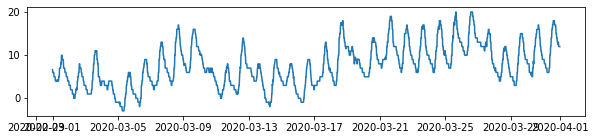

In [10]:
## 데이터가 갑자기 상승하는 데이터는 보정
temp_df = df.copy()

temp_df['경기대표 외기온도'] = np.where((abs(temp_df['경기대표 외기온도'] - temp_df['경기대표 외기온도'].shift(1)) > 3) &
                                (temp_df['경기대표 외기온도'] > temp_df['경기대표 외기온도'].shift(1)), np.NaN, temp_df['경기대표 외기온도']) ## 3도이상 상승하는 255개의 값을 NaN으로 변경
temp_df['경기대표 외기온도'] = temp_df['경기대표 외기온도'].interpolate(method = 'polynomial', order = 2) ## 다항식으로 NaN 보간법 진행
df = temp_df.copy() ## 변경 데이터 저장

year = [2020]
month = [3]
temp_df = temp_df[(temp_df['year'].isin(year)) & (temp_df['month'].isin(month))]

plt.figure(figsize = (10,2))
plt.plot(temp_df['시간'], temp_df['경기대표 외기온도'])
plt.show()

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


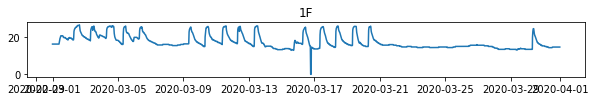

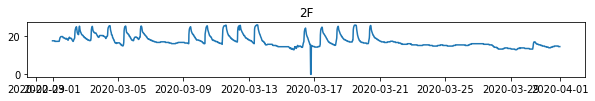

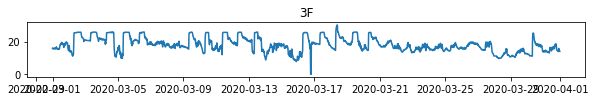

In [11]:
## 환기온도가 0인 경우는 통신이 끊겼을 때 생기는 현상으로 오류사항 (보정 필요)
temp_df = df.copy()
year = [2020]
month = [3]

for floor in eda_floor:
    temp_df[f'AHU_{floor}_환기온도'] = np.where((temp_df[f'AHU_{floor}_환기온도'] == 0) &
                               (abs(temp_df[f'AHU_{floor}_환기온도'] - temp_df[f'AHU_{floor}_환기온도'].shift(1)) > 3),
                               np.NaN, temp_df[f'AHU_{floor}_환기온도'])
    temp_df[f'AHU_{floor}_환기온도'] = temp_df[f'AHU_{floor}_환기온도'].interpolate(method = 'polynomial', order = 2) ## 다항식으로 NaN 보간법 진행    

    temp_df_2 = temp_df[(temp_df['year'].isin(year)) & (temp_df['month'].isin(month))]
    plt.figure(figsize = (10,1))
    plt.plot(temp_df_2['시간'], temp_df_2[f'AHU_{floor}_환기온도'])
    plt.title(floor)
    plt.show()    
df = temp_df.copy() ## 변경 데이터 저장

In [12]:
## Split data as floor
for floor in eda_floor:    
    globals()[f'floor_{floor}'] = []
    for column in list(df):
        if (len(column.split('_')) > 1) and (floor == column.split('_')[1]):          
            globals()[f'floor_{floor}'].append(column)
        elif (len(column.split('_')) > 2) and (floor == column.split('_')[2]):                     
            globals()[f'floor_{floor}'].append(column)
        elif (len(set(column.split('_')) & set(eda_floor)) == 0):
            globals()[f'floor_{floor}'].append(column)
    globals()[f'df_{floor}'] = df[globals()[f'floor_{floor}']].copy()    
    print(f"\n floor {floor} column num : {len(list(globals()[f'df_{floor}']))}")
    print(list(globals()[f'df_{floor}']))            
    print(globals()[f'df_{floor}'].shape)


 floor 1F column num : 17
['시간', 'AHU_1F_급기온도', 'AHU_1F_혼합온도', 'AHU_1F_환기온도', 'AHU_1F_급기휀상태', 'CH_CWR온도1', 'CH_CWR온도2', 'CH_CWS온도1', 'CH_CWS온도2', '경기대표 외기온도', 'FCU_AG_1F_상태1', 'FCU_AG_1F_상태2', 'FCU_BG_1F_상태1', 'FCU_BG_1F_상태2', 'FCU_BG_1F_상태3', 'year', 'month']
(105216, 17)

 floor 2F column num : 16
['시간', 'AHU_2F_급기온도', 'AHU_2F_혼합온도', 'AHU_2F_환기온도', 'AHU_2F_급기휀상태', 'CH_CWR온도1', 'CH_CWR온도2', 'CH_CWS온도1', 'CH_CWS온도2', '경기대표 외기온도', 'FCU_AG_2F_상태1', 'FCU_AG_2F_상태2', 'FCU_BG_2F_상태1', 'FCU_BG_2F_상태2', 'year', 'month']
(105216, 16)

 floor 3F column num : 13
['시간', 'AHU_3F_급기온도', 'AHU_3F_혼합온도', 'AHU_3F_환기온도', 'AHU_3F_급기휀상태', 'CH_CWR온도1', 'CH_CWR온도2', 'CH_CWS온도1', 'CH_CWS온도2', '경기대표 외기온도', 'FCU_BG_3F_상태', 'year', 'month']
(105216, 13)


## Data Filtering

In [13]:
floor_list = ['1F','2F','3F']
for floor in floor_list: 
    temp_df = globals()[f'df_{floor}'].copy()
    temp_df['hour'] = temp_df['시간'].dt.hour
    temp_df['날짜'] = pd.to_datetime(temp_df['시간']).dt.normalize()
    
    ## 4 ~ 10월 데이터 제거
    temp_df = temp_df[temp_df['month'].isin([1,2,3,11,12])].copy()

    ## AHU 가동시간이 하루에 1시간 이상인 일자 필터링
    oper_time = temp_df.groupby('날짜')[f'AHU_{floor}_급기휀상태'].sum().reset_index()    
    oper_time = oper_time[oper_time[f'AHU_{floor}_급기휀상태'] > 60]
    temp_df = temp_df[temp_df['날짜'].isin(oper_time['날짜'])]
    
    ## 일단위 AHU or FCU가 가동 하지 않는 시간 추출
    AHU_on = temp_df[(temp_df[f'AHU_{floor}_급기휀상태'] == 0) | (temp_df[[col for col in list(temp_df) if 'FCU' in col]].sum(axis =1) == 0)]
    temp_df = temp_df[temp_df['시간'].isin(AHU_on['시간'])]
        
    ## 가동된 이후 시간 제외
    temp_df = temp_df[temp_df['hour'] < 8]
        
    temp_df = pd.merge(globals()[f'df_{floor}'][['시간']], temp_df, left_on = '시간', right_on = '시간', how = 'outer')
    temp_df.reset_index(drop = True, inplace = True)
    globals()[f'df_{floor[:1]}'] = temp_df.copy()

## Check Temper Pattern

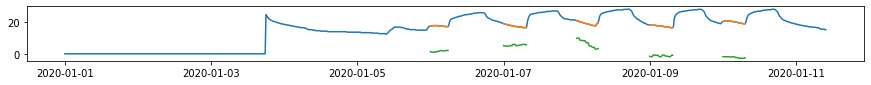

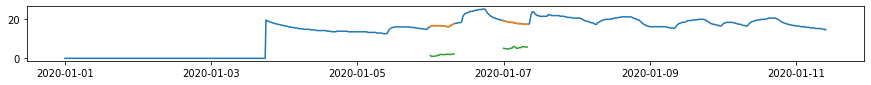

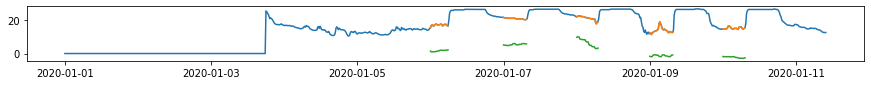

In [88]:
floor_list = ['1F','2F','3F']
for floor in floor_list:
    index = 1000
    temp_df = globals()[f'df_{floor[:1]}'][:index]
    temp_df_2 = globals()[f'df_{floor}'][:index]

    plt.figure(figsize = (15,1))
    plt.plot(temp_df_2['시간'], temp_df_2[f'AHU_{floor}_환기온도'])
    plt.plot(temp_df['시간'], temp_df[f'AHU_{floor}_환기온도'])
    plt.plot(temp_df['시간'], temp_df[f'경기대표 외기온도'])

    plt.show()

-9.0
31.1787
15.846677754640023
26.708036548474738
5.167981864178196


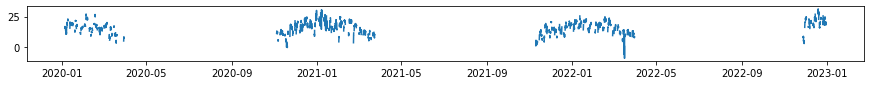

-9.0
27.536700000000003
16.802428755527593
19.514461288717996
4.417517548207137


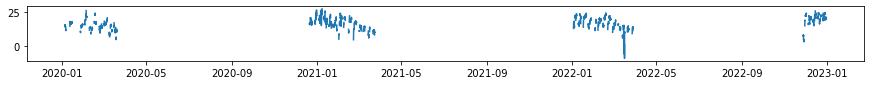

-9.0
23.886699999999998
13.247705511763662
13.652375598812743
3.6949121232869317


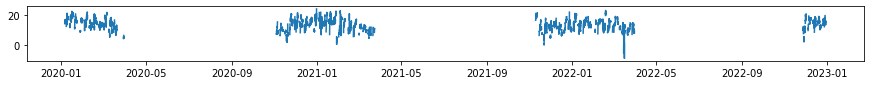

In [15]:
floor_list = ['1F','2F','3F']
for floor in floor_list:
    temp_df = globals()[f'df_{floor[:1]}']
    temp_value = pd.DataFrame(columns = ['temp_diff'], data = temp_df[f'AHU_{floor}_환기온도'] - temp_df[f'경기대표 외기온도'])
    print(temp_value[~temp_value['temp_diff'].isna()]['temp_diff'].min())
    print(temp_value[~temp_value['temp_diff'].isna()]['temp_diff'].max())
    print(temp_value[~temp_value['temp_diff'].isna()]['temp_diff'].mean())
    print(temp_value[~temp_value['temp_diff'].isna()]['temp_diff'].var())    
    print(temp_value[~temp_value['temp_diff'].isna()]['temp_diff'].std())    
       
    plt.figure(figsize = (15,1))
    plt.plot(temp_df['시간'], temp_value)
    plt.show()

## 환기온도 추론 모델 테스트

In [16]:
## Create Model Dataset
model_df = pd.DataFrame()
floor_list = ['1F','2F','3F']
for floor in floor_list:
    temp_df = globals()[f'df_{floor[:1]}'][[f'AHU_{floor}_환기온도', '경기대표 외기온도', 'month', 'hour']]
    temp_df.rename(columns = {f'AHU_{floor}_환기온도' : '환기온도'}, inplace = True)
    temp_df = temp_df[~temp_df['환기온도'].isna()]
    temp_df['floor'] = floor
    model_df = pd.concat([model_df, temp_df])
model_df['temp_diff'] = model_df['환기온도'] - model_df['경기대표 외기온도']
model_df = pd.concat([model_df, pd.get_dummies(model_df['floor'])], axis = 1)
del model_df['floor']
del model_df['temp_diff']

/usr/local/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [29]:
## Split Train/Test Data
from sklearn.model_selection import train_test_split

data_x = model_df[[col for col in list(model_df) if col != '환기온도']]
data_y = model_df[['환기온도']]
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size = 0.3, random_state = 1004)

In [56]:
## Random Forest Model
rf_model = RandomForestRegressor()
rf_model.fit(train_x, train_y)

<ipython-input-56-75e6a0352a31>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(train_x, train_y)


RandomForestRegressor()

In [70]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'Malgun Gothic'

['경기대표 외기온도', 'month', 'hour', '1F', '2F', '3F']


/usr/local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Glyph 50808 (\N{HANGUL SYLLABLE OE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/site-packages/IPyth

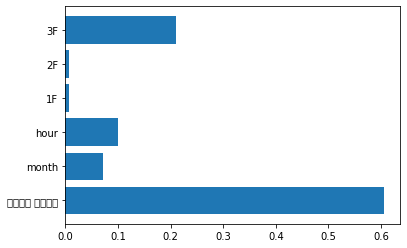

In [73]:
print(list(train_x))
plt.barh(list(train_x), rf_model.feature_importances_)
plt.show()

0.9234093146274343
0.7557969128460983
1.9262032244256675


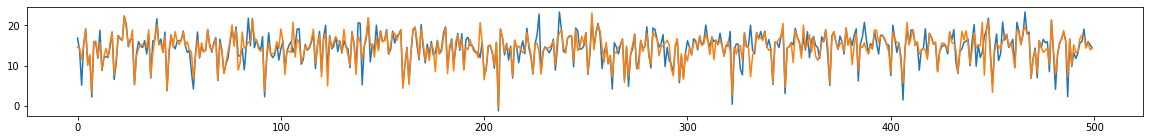

In [61]:
print(rf_model.score(train_x, train_y))
print(rf_model.score(test_x, test_y))
print(np.sqrt(mean_squared_error(test_y, rf_model.predict(test_x))))
plt.figure(figsize = (20,2))
plt.plot(test_y['환기온도'][:500].values)
plt.plot(rf_model.predict(test_x)[:500])
plt.show()

In [74]:
from tensorflow.keras import losses, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import EarlyStopping

K.clear_session()

model = Sequential()
model.add(Dense(32, activation = 'relu', input_shape=[6]))
model.add(Dense(16, activation = 'sigmoid'))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss=['mse'])    

callback = EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_x, train_y, validation_split = 0.2, epochs = 100, verbose=0, callbacks=callback)

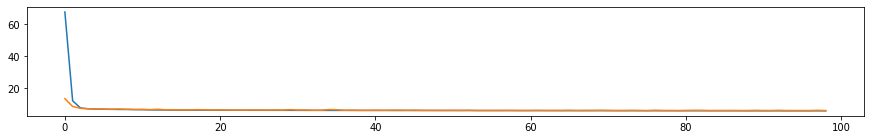

In [75]:
plt.figure(figsize = (15,2))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [76]:
print(np.sqrt(mean_squared_error(test_y, model.predict(test_x))))

2.484969452855897


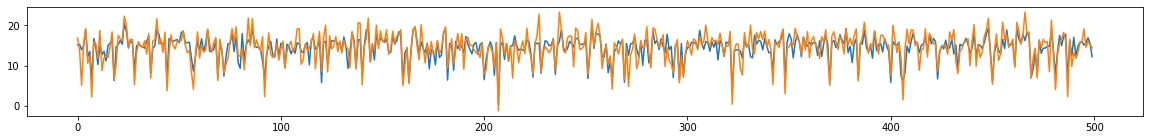

In [77]:
plt.figure(figsize = (20,2))
plt.plot(model.predict(test_x)[:500])
plt.plot(test_y.reset_index(drop = True)[:500])

plt.show()

In [90]:
from scipy import stats  

def confidence_interval(data, confidence = 0.95):
    data = np.array(data)
    mean = np.mean(data)
    n = len(data)

    # Standard Error of Mean (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.sem.html)
    stderr = stats.sem(data)

    # length_of_one_interval
    interval = stderr * stats.t.ppf( (1 + confidence) / 2 , n-1) # ppf : inverse of cdf

    return (mean, mean - interval, mean + interval, interval)

In [81]:
model.predict(test_x)

array([[15.183638],
       [15.296032],
       [13.94211 ],
       ...,
       [17.771189],
       [15.024509],
       [18.14977 ]], dtype=float32)

In [92]:
a,b,c,_inter = confidence_interval(abs(test_y - model.predict(test_x)))

In [95]:
model.predict(test_x) + _inter

array([[15.2236299 ],
       [15.33602423],
       [13.98210234],
       ...,
       [17.81118102],
       [15.06450171],
       [18.18976302]])

In [94]:
model.predict(test_x) - _inter

array([[15.14364534],
       [15.25603967],
       [13.90211778],
       ...,
       [17.73119645],
       [14.98451715],
       [18.10977845]])

In [113]:
pd.DataFrame(model.predict(test_x)[:100])

,0
0,15.183638
1,15.296032
2,13.942110
3,14.996857
4,19.014627
...,...
95,16.064497
96,12.759567
97,12.188317
98,16.616594


ValueError: need at least one array to concatenate

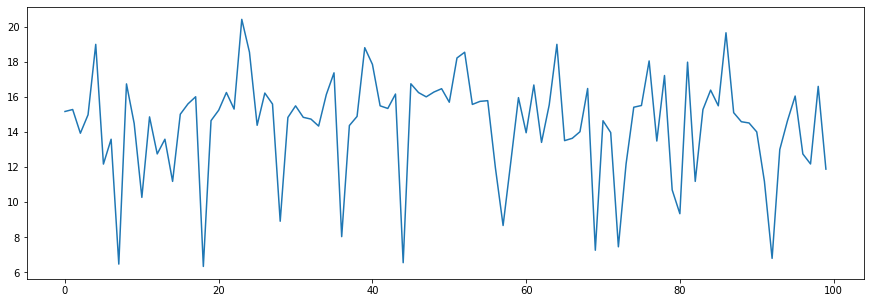

In [115]:
import seaborn as sns

plt.figure(figsize = (15,5))
plt.plot(model.predict(test_x)[:100])
ax = sns.regplot(data = pd.DataFrame(model.predict(test_x)[:100]), ci=90)
